In [1]:
using PyPlot
using JuLIP, JuLIP.ASE, JuLIP.Potentials, JuLIP.Constraints 
using ForwardDiff

function layers(at)
    dz = 1/(2*√2) * ( bulk("Si", cubic=true) |> defm )[1,1]
    X = positions(at) |> mat
    x, y, z = X[1,:], X[2,:], X[3,:] 
    I0 = find(z .<= 0.5*dz)
    I1 = find(0.5*dz .< z .<= 1.5*dz)
    I2 = find(1.5*dz .< z .<= 2.5*dz)
    I3 = find(z .> 2.5*dz)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]'], [x[I2]'; y[I2]'], [x[I3]'; y[I3]']
end 

function plot_layers(at, x0=nothing)
    X0, X1, X2, X3 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    plot(X2[1,:], X2[2,:], "r.", markersize=8)
    plot(X3[1,:], X3[2,:], "y.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end

reload("JuLIPMaterials")
Si = JuLIPMaterials.Si
sw = Si.sw_eq()
;

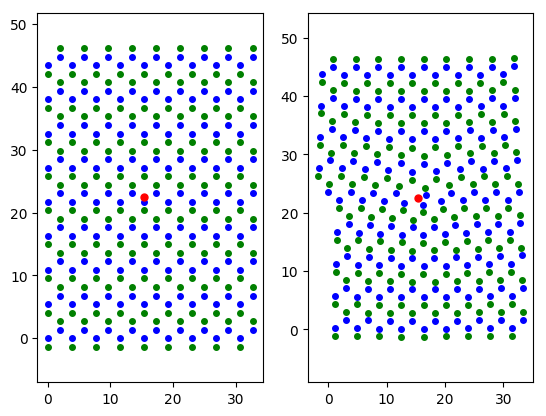

(-3.51275772303293, 35.13360538724363, -3.63237471710787, 48.825466188499156)

In [2]:
at, _, x0 = Si.si110_cluster("Si", 9)
edge, xc = Si.edge110("Si", 9)
figure()
subplot(1,2,1)
plot_layers(at, x0)
axis("equal")
subplot(1,2,2)
plot_layers(edge, x0)
axis("equal")

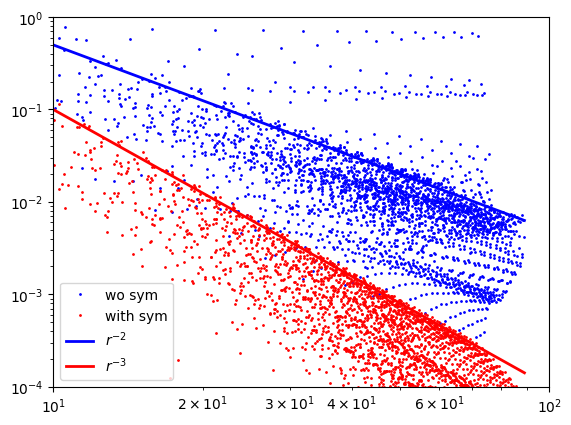

4-element Array{Float64,1}:
  10.0   
 100.0   
   0.0001
   1.0   

In [3]:
R = 31

at_nosym, xc = Si.edge110("Si", R; calc = sw, sym=false)
r_nosym = [norm(x - xc) for x in positions(at_nosym)]
f_nosym = norm.(forces(at_nosym))

at_sym, xc = Si.edge110("Si", R; calc = sw, sym=true)
r_sym = [norm(x - xc) for x in positions(at_sym)]
f_sym = norm.(forces(at_sym))

# plotting preparation
r0 = rnn("Si")*2
x, y, _ = xyz(at_sym)
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = find( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )
s = [extrema(r_sym)...]
r_sym, f_sym, r_nosym, f_nosym = r_sym[Iint], f_sym[Iint], r_nosym[Iint], f_nosym[Iint]

s = [extrema(r_sym)...]
loglog(r_nosym, f_nosym, "b.", markersize=2, label = "wo sym")
loglog(r_sym, f_sym, "r.", markersize=2, label = "with sym")
loglog(s, 50*s.^(-2), "b-", linewidth = 2.0, label = L"r^{-2}") 
loglog(s, 100*s.^(-3), "r-", linewidth = 2.0, label = L"r^{-3}")
legend(loc="lower left")
axis([10, 100, 1e-4, 1.0])